# Ch 8. Using convolutions to generalize
---
>- 컨볼루션 이해
>- 컨볼루션 신경망 만들기
>- 커스텀 `nn.Module` 만들기
>- 모듈과 함수형 API의 차이
>- 신경망 설계시 고려할 점

### 8.1 컨볼루션
기존 모델에서 인접한 픽셀들을 들여다보도록 하는 것과 평행이동 불변성(Translation invarance)을 얻어야 한다는 것을 알았다.

먼저 인접한 픽셀의 배열 방식을 살펴보도록 하는 것을 수학적으로 나타내면 다음과 같다. 인접한 픽셀에 대한 가중치의 합을 구하는 것이다. 출력 피쳐와 출력 픽셀 위치마다 가중치 행렬을 만들어서 중심이 되는 픽셀에서 일정 거리 멀어지면 가중치가 0이 되는 방식이다.

다음으로 평행이동 불변성을 얻기 위해선 가중치 행렬 대부분을 0으로 만들고 입력에 대해 상대적으로 같은 위치에 있는 엔트리가 출력 픽셀에 동일한 영향을 줄 방법을 찾아야한다. 이처럼 이미지에 대해 평행이동 불변성을 보장하는 선형 연산이 **컨볼루션**(**Convolution**)이다.

우리가 사용할 **이산 컨볼루션**(**Discrete Convolution**)은 **커널**(**kernerl**)이라고 불리는 가중치 행렬에 스칼라 곱으로 표현된 2D 이미지에 대해 정의된다. 이 연산을 입력의 모든 이웃에 대해 수행한다.

컨볼루션 연산은 아래 그림과 같이 진행된다. 커널이 입력의 모든 위치로 이동하면서 가중치의 합을 구해 출력 이미지를 만들어낸다. 이때 동일한 커널이 전체 이미지에 대해 계속 사용된다는 점을 기억하자.

- 인접 영역에 대한 지역 연산을 할 수 있고,
- 평행이동 불변성을 가지며,
- 더 적은 파라미터를 사용한다.


![image](https://user-images.githubusercontent.com/76675506/189580319-d625c1b6-b845-4647-9337-e49cac56dcfe.png)



In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [6]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100.0%


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


In [8]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

- `nn.Conv1d`: 시계열
- `nn.Conv2d`: 이미지
- `nn.Conv3d`: 용적 데이터, 동영상

`nn.Conv2d`는 최소 입력 피처 수, 출력 피처 수, 커널 크기를 인자로 받는다.

In [9]:
conv = nn.Conv2d(3, 16, kernel_size=3).to(device='cuda') # 픽셀당 3개(RGB)의 입력 피처, 임의의 출력 피처 및 커널 크기
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

컨볼루션의 `weight`텐서는 `out_ch` X `in_ch` X `kernel` 형태로 나타난다.

In [10]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

`output`의 크기가 30x30으로 변한 것을 알 수 있다. 이는 이미지의 경계 부분에서의 작업에 따른 부작용이다. 컨볼루션 연산은 기본적으로 모든 방향에 값이 존재한다는 전제로 진행된다. 크기가 홀수인 컨볼루션 커널의 길이의 절반만큼 양쪽의 그림이 잘린다.

이를 보완할 수 있는 방법이 **패딩**(**padding**)이다.
![image](https://user-images.githubusercontent.com/76675506/189588794-986889ed-998e-4662-b8ba-84139edcbba0.png)

In [12]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0).to(device='cuda')) # B x C x H x W
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

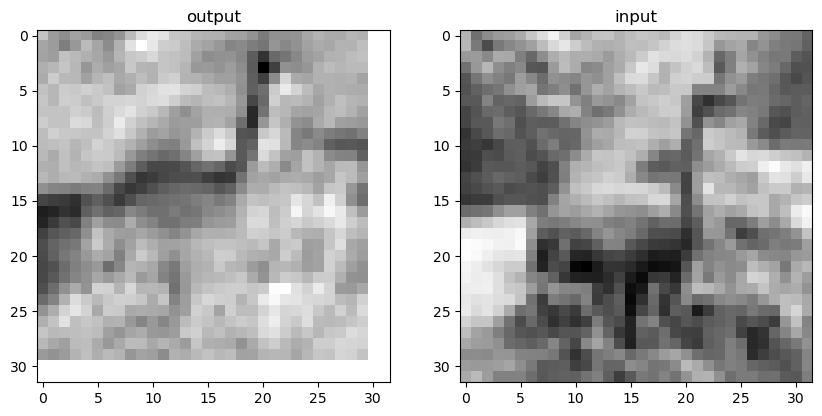

In [16]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0,0].to(device='cpu').detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

`kernel_size`가 3일 때 `padding`을 1로 지정하면 0,0 지점에서 왼쪽과 위쪽에 추가 인접 픽셀(가짜)이 만들어진다. 만약 커널 크기가 짝수라면 왼쪽과 오른쪽, 위와 아래를 각각 서로 다른 크기로 패딩해야 한다. `torch.nn.functional.pad`로 이를 구현할 수 있다. 하지만 통상 커널은 홀수 크기로 만드는 것을 추천한다.

패딩을 사용하는 이유를 정리하면 다음과 같다.
>- 이미지 크기 변경 문제를 예방할 수 있다.
>- 컨볼루션 구조 자체에 더 신경쓸 수 있다.

In [18]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

### 컨볼루션으로 피쳐 찾아내기
---
가중치 값을 변경해서 어떤 일이 일어나는지 확인해볼 수 있다.

In [19]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

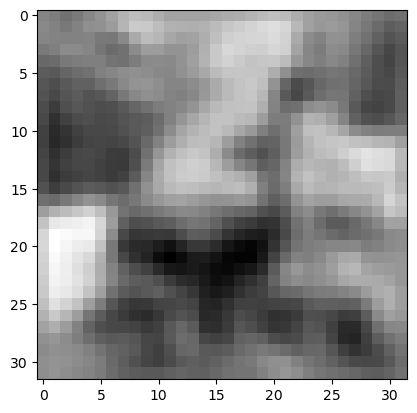

In [21]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

아래 커널 값은 오른쪽 픽셀에서 기준 픽셀의 왼쪽 픽셀을 빼는 계산을 수행한다. 만약 이미지에서 강도가 다른 두 인접한 영역 사이에서 수직 경계에 커널이 적용되면, 높은 값을 갖게 된다. 반면에 커널이 비슷한 색이나 밀도로 이뤄진 영역에서 수행됐다면 값이 0이 된다.
즉 가로로 인접한 두 영역 사이의 수직 경계를 탐색하는 역할을 한다. 결과물에서는 수직 경계가 강조된 효과를 얻을 수 있다.

이미지의 각 채널은 커널의 각 피처에 대응하게 된다. (한 채널은 평균, 다른 채널은 수직 경계선을 강조하는 경우를 생각해보자.)

In [25]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

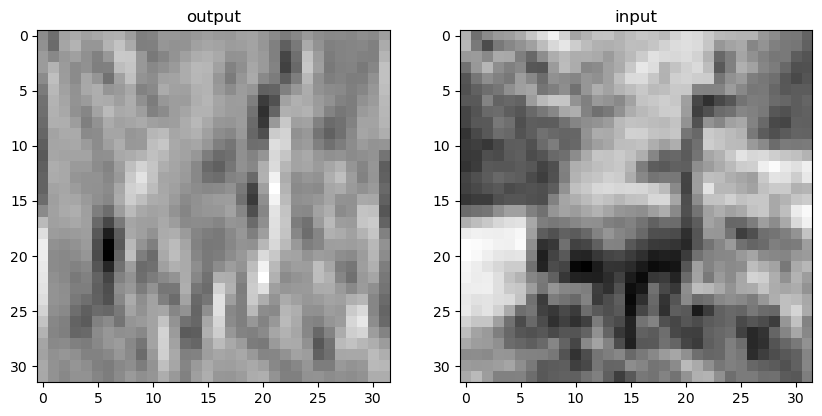

In [24]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

### 다운샘플링
---
3x3이나 5x5처럼 작은 커널을 사용한다면 큰 범위의 이미지를 인식할 때 문제가 생길 수 있다. 이를 해결하는 방법 중 하나로 다운 샘플링이 있다.
- **평균 풀링(Avarage Pooling)**: 최근에는 잘 사용하지 않는 방법
- **맥스 풀링(Max Pooling)**: 가장 많이 사용되지만 데이터의 4분의 3을 버린다는 단점이 있다. 아래 그림에 동작 원리가 나타나있다. 최댓값을 뽑는 것은 약한 신호를 버리고 살아남은 피처를 발견하는 과정으로 볼 수 있다.

- n번째 픽셀만 계산하면서 Strided convolution을 수행하는 방법: 3x4 컨볼루션을 스트라이드 2로 진행하면 이전 계층의 모든 픽셀을 포함한다. 맥스 풀링을 대체하진 못한다.
![image](https://user-images.githubusercontent.com/76675506/189616224-99f50235-2471-4b2a-8c75-280838641935.png)

In [26]:
pool = nn.MaxPool2d(2) # 풀링 연산을 수행할 인접한 영역 크기를 인자로 받는다. 2로 넣으면 이미지를 절반으로 줄이게 된다.
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

1. 8x8 이미지에 3x3 커널을 적용해서 같은 크기의 컨볼루션 출력 결과를 얻는다.
2. 출력 이미지에 대해 맥스 풀링을 적용해 4x4 크기의 이미지를 얻는다. 이 이미지에 다른 3x3 커널을 적용한다. 이 때의 커널 셋은 첫 번째 커널 셋의 피처를 받고 추가적인 피처를 추출한다.

![image](https://user-images.githubusercontent.com/76675506/189617954-258b285e-07ae-4e79-a2da-baba219c8967.png)

- 출력 픽셀의 수용필드
    - ㄹㅇㅁㄴ

아래 모델은
1. 첫 번째 컨볼루션은 3 RGB 채널을 16개의 피처를 만들어 새와 비행기에 대한 저수준의 피처를 찾아낸다.
2. 그 후 `Tanh` 활성 함수를 적용한다.
3. 위 결과로 만들어진 16채널의 32x32 이미지는 이제 첫 `MaxPool2d`를 통해 16x16 이미지로 다운샘플링된다.
4. 위 출력은 8채널 16x16 출력을 만드는 컨볼루션으로 들어간다. 이 출력은 더 높은 수준의 피처를 가지게 된다.
5. 그 후 `Tanh` 활성 함수를 거친다음
6. 8채널 8x8 출력을 위한 풀링을 거친다.
- 이 모델은 결국 NLL로 넣을 수 있는 확률값을 뽑아줘야 한다. 현재는 결과값이 멀티 채널의 2차원 피처인 상태다.

![image](https://user-images.githubusercontent.com/76675506/189625166-cdc0bcbb-79f1-48f8-9738-befe4fd1b322.png)

In [27]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), # 1
    nn.Tanh(),                                  # 2
    nn.MaxPool2d(2),                            # 3
    nn.Conv2d(16, 8, kernel_size=3, padding=1), # 4
    nn.Tanh(),                                  # 5
    nn.MaxPool2d(2),                            # 6
    # 빠진 부분이 있다.
    nn.Linear(8*8*8, 32),                       # 7
    nn.Tanh(),                                  # 8
    nn.Linear(32, 2)                            # 9
)

In [29]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [33]:
# Linear에 넣기 전 형태를 바꿔야 하지만 Sequential을 사용할 땐 모듈의 출력을 명시적으로 볼 수 없다.
try:
    model(img.unsqueeze(0))

except RuntimeError as e:
    print(e)

mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)


### nn.Module 서브클래싱하기
---
신경망을 개발하다 보면 지원하지 않는 연산이 필요할 때가 있다. 이 때는 `nn.Module`의 서브클래스를 직접 만들어야 한다. 서브클래스를 만들 때 주의해야 할 점은 아래와 같다.

- `forward` 함수를 먼저 정의해서 입력을 받고 출력을 반환할 수 있도록 해야한다. 파이토치 연산만 사용하면 자동미분 기능이 역방향 경로를 만들어주기 때문에 `backward`는 필요 없다.
- `super().__init__()`을 호출해야 한다.

In [34]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1),
        self.act2 = nn.Tanh(),
        self.pool2 = nn.MaxPool2d(2),
        self.fc1 = nn.Linear(8*8*8, 32),
        self.act3 = nn.Tanh(),
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act1(self.conv2(out)))
        out = out.view(-1, 8*8*8) # 차원 정보 변경
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

위 모델의 아키텍처를 나타내면 아래 그림과 같다.

1. 아웃풋 값의 개수가 점점 줄어드는 모습
2. 최초의 컨볼루션에서는 입력 크기에 대해 출력 크기가 줄어들지 않는다.

![image](https://user-images.githubusercontent.com/76675506/189636843-b631d3a9-758b-4d94-99f1-811b71cd1225.png)